<a href="https://colab.research.google.com/github/OvaTech-AI/cnn_vgg16_ultrasounds/blob/main/Ultrasound_Team.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-processing & Data augmentation

In [ ]:
# Importing stuff

import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR
import torchvision

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [ ]:
# Mount to Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.manual_seed(12)

#####################
#### batch_size = 50
#### img_height = img_width = 300

batch_size = 64
img_height = img_width = 224

directory = "/content/drive/MyDrive/ultrasounds/train"
test_dir = "/content/drive/MyDrive/ultrasounds/test"

# Transforms for training, validation, and testing
transform = transforms.Compose([
    transforms.Resize ((img_height, img_width)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.Normalize ((0.5,), (0.5,))
])

# Load the datasets
full_dataset = datasets.ImageFolder(root=directory, transform=transform)
class_names = full_dataset.classes

# Split the dataset into training and validation sets
train_size = int(0.85 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders for training and validation
train_loader = DataLoader (train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader (val_dataset, batch_size=batch_size, shuffle=True)

# Test dataset and DataLoader
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader (test_dataset, batch_size=batch_size, shuffle=False)

<Figure size 1000x1000 with 0 Axes>

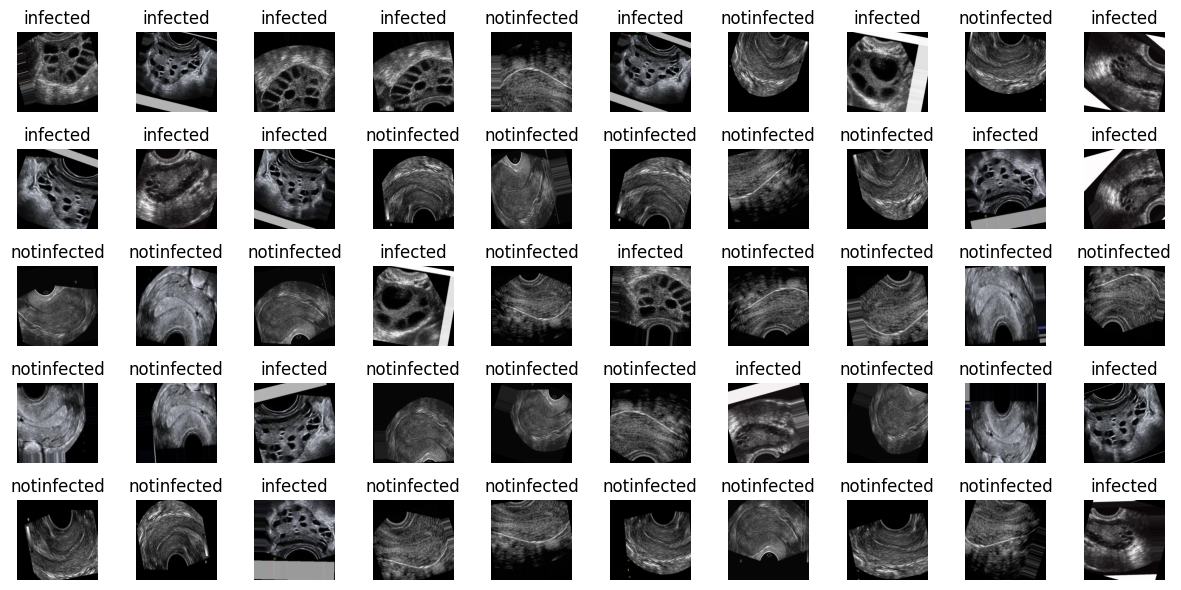

In [ ]:
# Display some training images
plt.figure(figsize=(10, 10))

def imshow (img, ax, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    ax.imshow (np.transpose(npimg, (1, 2, 0)))
    ax.set_title (title)
    ax.axis ('off')

dataiter = iter (train_loader)
images, labels = next (dataiter)

# Plot images with labels above (infected or not infected)
fig, axes = plt.subplots (5, 10, figsize = (12, 6))
axes = axes.flatten()

for img, ax, label in zip(images[:50], axes, labels[:50]):
    imshow (img, ax, class_names[label])

plt.tight_layout()
plt.show()

# CNN with VGGNet16

In [ ]:
class PCOSModel (nn.Module):
    def __init__(self):
        super().__init__()

        # Fine Tuning Layer (VGG16 pre-trained model excluding fully connected layers)
        self.vgg16 = models.vgg16 (pretrained= True)
        self.vgg16_features = nn.Sequential(*list(self.vgg16.features.children()))

        # Adding new layers
        self.conv_layer = nn.Conv2d (in_channels=512, out_channels=512, kernel_size=7, stride=1, padding='same')
        self.max_pool = nn.MaxPool2d (kernel_size=2, stride=2)
        self.dropout = nn.Dropout (p=0.4)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear (512, 2)



    def forward (self, x):
        x = self.vgg16_features(x)

        x = F.relu (self.conv_layer(x))
        x = self.max_pool (x)
        x = F.relu (self.conv_layer(x))
        x = self.max_pool (x)
        x = self.dropout (x)

        x = self.flatten (x)

        x = self.fc (x)

        return x


In [ ]:
# Instantiate the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = PCOSModel ()
model = model.to (device)

In [ ]:
num_epochs = 20

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
## Training Loop using cross-validation

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

    # Validation step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / total
    print (f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/ultrasounds/pcos_model_2.pth')
print ('Model saved to pcos_model.pth')

Epoch 1/20, Training Loss: 0.6871
Epoch 1/20, Validation Loss: 0.6856, Validation Accuracy: 0.6263
Epoch 2/20, Training Loss: 0.6876
Epoch 2/20, Validation Loss: 0.6847, Validation Accuracy: 0.6298
Epoch 3/20, Training Loss: 0.6885
Epoch 3/20, Validation Loss: 0.6856, Validation Accuracy: 0.6263
Epoch 4/20, Training Loss: 0.6889
Epoch 4/20, Validation Loss: 0.6855, Validation Accuracy: 0.6298
Epoch 5/20, Training Loss: 0.6881
Epoch 5/20, Validation Loss: 0.6853, Validation Accuracy: 0.6332
Epoch 6/20, Training Loss: 0.6867
Epoch 6/20, Validation Loss: 0.6848, Validation Accuracy: 0.6298
Epoch 7/20, Training Loss: 0.6892
Epoch 7/20, Validation Loss: 0.6855, Validation Accuracy: 0.6298
Epoch 8/20, Training Loss: 0.6876
Epoch 8/20, Validation Loss: 0.6852, Validation Accuracy: 0.6263


KeyboardInterrupt: 

In [ ]:
# Evaluation on the test set
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to (device)
        labels = labels.to (device)
        outputs = model (inputs)
        loss = criterion (outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max (outputs, 1)
        total += labels.size (0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
test_accuracy = correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Test Loss: 0.0130, Test Accuracy: 0.9948
